In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Standard tqdm for progress bar

# Configuration
MEASUREMENTS_FILE = 'measurements_level3_v11.csv'
PARAMS_FILE = 'mosfet_params_level3_v11.csv'



In [28]:
def load_data(measurements_file, params_file):
    """Load the measurement and parameter CSV files into DataFrames."""
    try:
        df_meas = pd.read_csv(measurements_file)
        print(f"Loaded {measurements_file}")
    except FileNotFoundError:
        print(f"Error: {measurements_file} not found.")
        df_meas = pd.DataFrame()

    try:
        df_params = pd.read_csv(params_file)
        print(f"Loaded {params_file}")
    except FileNotFoundError:
        print(f"Error: {params_file} not found.")
        df_params = pd.DataFrame()

    return df_meas, df_params

# Load data once
df_meas, df_params = load_data(MEASUREMENTS_FILE, PARAMS_FILE)

Loaded measurements_level3_v11.csv
Loaded mosfet_params_level3_v11.csv


In [29]:
VDS_SATURATION = 5.0  # Vds value for saturation region data
VGS_LINEAR_THRESHOLD_LOW = 0.5    # Adjust if needed
VGS_LINEAR_THRESHOLD_HIGH = 2   # Adjust if needed

In [ ]:
import time  # Add this to measure execution time

def process_mosfets(df_meas, df_params, num_devices, vds_saturation, vgs_low, vgs_high):
    """Process MOSFET data and calculate Vth for a specified number of devices, with timing."""
    results = []

    if not df_meas.empty and not df_params.empty:
        unique_mosfet_ids = sorted(df_meas['MOSFET_ID'].unique())
        # Limit the number of devices if specified
        if num_devices is not None:
            unique_mosfet_ids = unique_mosfet_ids[:num_devices]
            print(f"\nProcessing first {num_devices} of {len(df_meas['MOSFET_ID'].unique())} MOSFETs...")
        else:
            print(f"\nProcessing all {len(unique_mosfet_ids)} MOSFETs...")

        # Start timing
        start_time = time.time()

        for mosfet_id in tqdm(unique_mosfet_ids, desc="Calculating Vth"):
            # 1. Filter measurements for current MOSFET
            df_single_mosfet = df_meas[df_meas['MOSFET_ID'] == mosfet_id]

            # 2. Filter for saturation region data
            df_sat = df_single_mosfet[np.isclose(df_single_mosfet['VDS'], vds_saturation)].copy()

            if df_sat.empty:
                print(f"Warning: No saturation data (Vds={vds_saturation}V) found for MOSFET_ID {mosfet_id}. Skipping.")
                continue

            # 3. Calculate SQRT_ID
            df_sat['SQRT_ID'] = np.sqrt(df_sat['ID'].clip(lower=1e-15))

            # 4. Select linear region for extrapolation
            df_linear_region = df_sat[
                (df_sat['VGS'] > vgs_low) &
                (df_sat['VGS'] <= vgs_high) &
                (df_sat['ID'] > 0)
            ]

            vth_extrapolated = np.nan

            # 5. Perform linear fit if enough points exist
            if len(df_linear_region) >= 2:
                vgs_linear = df_linear_region['VGS']
                sqrt_id_linear = df_linear_region['SQRT_ID']

                try:
                    slope, intercept = np.polyfit(vgs_linear, sqrt_id_linear, 1)
                    if slope != 0:
                        vth_extrapolated = -intercept / slope
                    else:
                        print(f"Warning: Zero slope detected for MOSFET_ID {mosfet_id}. Cannot extrapolate Vth.")
                except np.linalg.LinAlgError:
                    print(f"Warning: Linear fit failed for MOSFET_ID {mosfet_id}.")
            # else: Vth remains NaN, no warning needed

            # 6. Get actual Vth (VTO) from params file
            actual_params = df_params[df_params['MOSFET_ID'] == mosfet_id]
            if not actual_params.empty:
                actual_vth = actual_params['VTO'].iloc[0]
            else:
                print(f"Warning: Parameters not found for MOSFET_ID {mosfet_id}. Cannot calculate error.")
                actual_vth = np.nan

            # 7. Calculate Percentage Error
            percent_error = np.nan
            if not np.isnan(vth_extrapolated) and not np.isnan(actual_vth):
                if actual_vth != 0:
                    percent_error = abs((vth_extrapolated - actual_vth) / actual_vth) * 100
                elif vth_extrapolated == 0:
                    percent_error = 0.0
                else:
                    percent_error = float('inf')

            # 8. Store results
            results.append({
                'MOSFET_ID': mosfet_id,
                'Actual_Vth (VTO)': actual_vth,
                'Extrapolated_Vth': vth_extrapolated,
                'Percentage_Error': percent_error
            })

        # End timing
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nTime taken to calculate Vth for {len(unique_mosfet_ids)} MOSFETs: {elapsed_time:.2f} seconds")

        return pd.DataFrame(results)
    else:
        print("\nCannot proceed without both measurement and parameter data files.")
        return pd.DataFrame()

# Example usage: Change NUM_DEVICES here as needed
NUM_DEVICES = 10000  # You can modify this value
df_results = process_mosfets(
    df_meas, df_params, NUM_DEVICES, VDS_SATURATION,
    VGS_LINEAR_THRESHOLD_LOW, VGS_LINEAR_THRESHOLD_HIGH
)


Processing first 11000 of 55000 MOSFETs...


Calculating Vth: 100%|██████████| 11000/11000 [06:04<00:00, 30.20it/s]


Time taken to calculate Vth for 11000 MOSFETs: 364.30 seconds



--- Vth Calculation and Comparison Results ---
       MOSFET_ID  Actual_Vth (VTO)  Extrapolated_Vth  Percentage_Error
0              1            0.6372            0.5862            8.0133
1              2            1.0249            0.9939            3.0199
2              3            0.4459            0.2548           42.8723
3              4            0.3335           -0.0981          129.4254
4              5            0.6023            0.5292           12.1337
...          ...               ...               ...               ...
10995      10996            0.4448            0.3434           22.8018
10996      10997            1.0146            0.9903            2.3897
10997      10998            0.8506            0.7575           10.9442
10998      10999            0.6738            0.6246            7.3045
10999      11000            0.9251            0.8999            2.7227

[11000 rows x 4 columns]

--- Summary Statistics for Percentage Error ---
Mean Error: 17.39%
Median

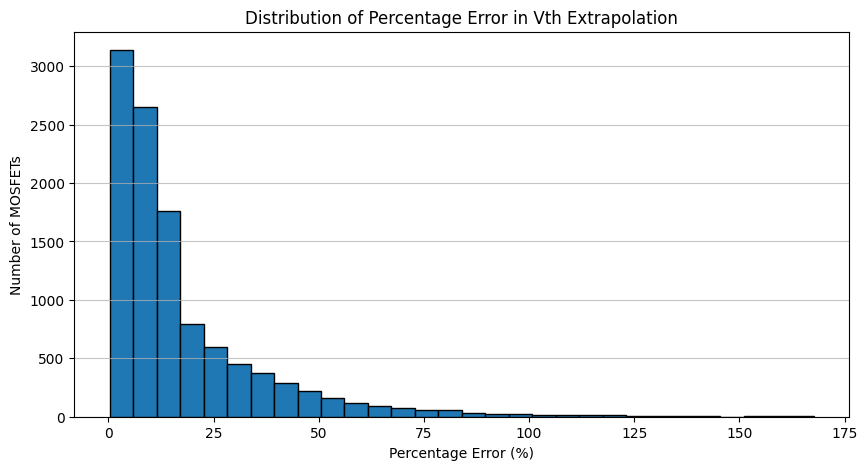

In [31]:
def display_results(df_results, num_devices):
    """Display results and analyze percentage errors."""
    if not df_results.empty:
        print("\n--- Vth Calculation and Comparison Results ---")
        with pd.option_context('display.max_rows', 10, 'display.float_format', '{:,.4f}'.format):
            print(df_results)

        # Analyze Percentage Error
        valid_errors = df_results['Percentage_Error'].dropna().replace([np.inf, -np.inf], np.nan).dropna()
        if not valid_errors.empty:
            print("\n--- Summary Statistics for Percentage Error ---")
            print(f"Mean Error: {valid_errors.mean():.2f}%")
            print(f"Median Error: {valid_errors.median():.2f}%")
            print(f"Standard Deviation: {valid_errors.std():.2f}%")
            print(f"Min Error: {valid_errors.min():.2f}%")
            print(f"Max Error: {valid_errors.max():.2f}%")
            print(f"Number of MOSFETs with valid error calculation: {len(valid_errors)} / {len(df_results)}")

            # Plot histogram of errors
            plt.figure(figsize=(10, 5))
            plt.hist(valid_errors, bins=30, edgecolor='black')
            plt.title('Distribution of Percentage Error in Vth Extrapolation')
            plt.xlabel('Percentage Error (%)')
            plt.ylabel('Number of MOSFETs')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
        else:
            print("\nNo valid percentage errors calculated to summarize.")

# Display the results from the previous processing
display_results(df_results, NUM_DEVICES)